In [1]:
import pandas as pd
import numpy as np

# Загрузка данных
df = pd.read_excel('Data_Asya.xlsx')

features = [
    ('Date_Portfolio_USD', 'Portfolio_USD'),
    ('Date_Natural Gas EU Dutch TTF (EUR/Wh)', 'Natural Gas EU Dutch TTF (EUR/Wh)'),
    # ('Date_U.S.Crude Oil Inventories', 'U.S.Crude Oil Inventories'),
    ('Date_United States Fed Funds Interest Rate', 'United States Fed Funds Interest Rate'),
    ('Date_Brent Oil Futures - Jun 25 (LCO5)', 'Brent Oil Futures - Jun 25 (LCO5)')
]

result_df = pd.DataFrame()

for date_col, value_col in features:
    # Создаем временный DataFrame для каждого признака
    temp_df = df[[date_col, value_col]].copy()

    # Преобразуем даты и значения
    temp_df[date_col] = pd.to_datetime(temp_df[date_col], format='%d.%m.%Y', errors='coerce').dt.normalize()  # Убираем время
    temp_df[value_col] = pd.to_numeric(temp_df[value_col], errors='coerce')

    # Удаляем строки с невалидными датами и дубликаты
    temp_df = temp_df.dropna(subset=[date_col])
    temp_df = temp_df.drop_duplicates(subset=[date_col], keep='last')

    # Переименовываем столбец с датой для унификации
    temp_df = temp_df.rename(columns={date_col: 'Date'})

    # Объединяем данные
    if result_df.empty:
        result_df = temp_df
    else:
        result_df = pd.merge(result_df, temp_df, on='Date', how='outer')

# Сортируем по дате и сбрасываем индекс
result_df = result_df.sort_values('Date').reset_index(drop=True)

# Выводим статистику ДО преобразования даты в строку
# print("Статистика числовых столбцов:")
# print(result_df.describe())
# print(result_df)

# Форматируем даты для Excel
# result_df['Date'] = result_df['Date'].dt.strftime('%Y-%m-%d')

# Сохраняем в Excel
# result_df.to_excel('result_data.xlsx', index=False)

result_df['Date'] = pd.to_datetime(result_df['Date'])
result_df = result_df.set_index('Date')
# Приводим индекс к формату datetime
result_df.index = pd.to_datetime(result_df.index)

# Создаем полный диапазон дат
full_index = pd.date_range(start=result_df.index.min(), end=result_df.index.max(), freq='D')
result_df = result_df.reindex(full_index)

print("Количество пропусков до интерполяции:")
print(result_df.isnull().sum())
print(result_df.dtypes)
print(result_df.head())
print(result_df.describe)

Количество пропусков до интерполяции:
Portfolio_USD                            1533
Natural Gas EU Dutch TTF (EUR/Wh)        1414
United States Fed Funds Interest Rate    4238
Brent Oil Futures - Jun 25 (LCO5)        1283
dtype: int64
Portfolio_USD                            float64
Natural Gas EU Dutch TTF (EUR/Wh)        float64
United States Fed Funds Interest Rate    float64
Brent Oil Futures - Jun 25 (LCO5)        float64
dtype: object
            Portfolio_USD  Natural Gas EU Dutch TTF (EUR/Wh)  \
2013-01-02     988.839122                                NaN   
2013-01-03     997.739901                                NaN   
2013-01-04    1016.371927                               27.2   
2013-01-05            NaN                                NaN   
2013-01-06            NaN                                NaN   

            United States Fed Funds Interest Rate  \
2013-01-02                                    NaN   
2013-01-03                                    NaN   
2013-01-04 

In [2]:
target_col = 'Portfolio_USD'
feature_cols = ['Portfolio_USD',
                'Natural Gas EU Dutch TTF (EUR/Wh)',
                # 'U.S.Crude Oil Inventories',
                'United States Fed Funds Interest Rate',
                'Brent Oil Futures - Jun 25 (LCO5)']
df = result_df[feature_cols].copy()

In [3]:
# параметры
lookback = 30  # история
horizon = 14   # прогноз

# Размер теста = lookback + horizon
test_size = lookback + horizon

# Разделение данных
train = df.iloc[:-test_size]
test = df.iloc[-test_size:]

# Проверка дат
print("Начало теста:", test.index[0])  # Должно быть 2024-11-18
print("Прогнозируемый период:", test.index[-horizon:])  # 2024-12-01 — 2024-12-14

Начало теста: 2024-11-18 00:00:00
Прогнозируемый период: DatetimeIndex(['2024-12-18', '2024-12-19', '2024-12-20', '2024-12-21',
               '2024-12-22', '2024-12-23', '2024-12-24', '2024-12-25',
               '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', freq='D')


In [4]:
# Заполняем пропуски в трейне
train_imputed = train.copy()

# Для каждого признака свой метод
train_imputed['Portfolio_USD'] = train['Portfolio_USD'].interpolate(method='time').bfill()
train_imputed['Natural Gas EU Dutch TTF (EUR/Wh)'] = train['Natural Gas EU Dutch TTF (EUR/Wh)'].ffill()
# train_imputed['U.S.Crude Oil Inventories'] = train['U.S.Crude Oil Inventories'].fillna(train['U.S.Crude Oil Inventories'].median())  # еженедельные данные
train_imputed['United States Fed Funds Interest Rate'] = train['United States Fed Funds Interest Rate'].ffill()  # процентная ставка редко меняется
train_imputed['Brent Oil Futures - Jun 25 (LCO5)'] = train['Brent Oil Futures - Jun 25 (LCO5)'].interpolate(method='linear')
print("Количество пропусков в трейне после импьютации:")
print(train_imputed.isnull().sum())

Количество пропусков в трейне после импьютации:
Portfolio_USD                             0
Natural Gas EU Dutch TTF (EUR/Wh)         2
United States Fed Funds Interest Rate    28
Brent Oil Futures - Jun 25 (LCO5)         0
dtype: int64


In [5]:
# Для Natural Gas EU Dutch TTF
nan_gas = train_imputed[train_imputed["Natural Gas EU Dutch TTF (EUR/Wh)"].isna()]
print("Даты с пропусками в Natural Gas:\n", nan_gas.index)

# Для United States Fed Funds Interest Rate
nan_interest = train_imputed[train_imputed["United States Fed Funds Interest Rate"].isna()]
print("\nДаты с пропусками в Interest Rate:\n", nan_interest.index)

Даты с пропусками в Natural Gas:
 DatetimeIndex(['2013-01-02', '2013-01-03'], dtype='datetime64[ns]', freq='D')

Даты с пропусками в Interest Rate:
 DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05',
               '2013-01-06', '2013-01-07', '2013-01-08', '2013-01-09',
               '2013-01-10', '2013-01-11', '2013-01-12', '2013-01-13',
               '2013-01-14', '2013-01-15', '2013-01-16', '2013-01-17',
               '2013-01-18', '2013-01-19', '2013-01-20', '2013-01-21',
               '2013-01-22', '2013-01-23', '2013-01-24', '2013-01-25',
               '2013-01-26', '2013-01-27', '2013-01-28', '2013-01-29'],
              dtype='datetime64[ns]', freq='D')


In [6]:
train_imputed["Natural Gas EU Dutch TTF (EUR/Wh)"] = train_imputed["Natural Gas EU Dutch TTF (EUR/Wh)"].bfill()
# перепроверяем
nan_gas = train_imputed[train_imputed["Natural Gas EU Dutch TTF (EUR/Wh)"].isna()]
print("Даты с пропусками в Natural Gas:\n", nan_gas.index)

Даты с пропусками в Natural Gas:
 DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [7]:
train_imputed["United States Fed Funds Interest Rate"] = train_imputed["United States Fed Funds Interest Rate"].bfill()
# проверяем
nan_interest = train_imputed[train_imputed["United States Fed Funds Interest Rate"].isna()]
print("\nДаты с пропусками в Interest Rate:\n", nan_interest.index)


Даты с пропусками в Interest Rate:
 DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [8]:
print("Количество пропусков в трейне после импьютации:")
print(train_imputed.isnull().sum())

Количество пропусков в трейне после импьютации:
Portfolio_USD                            0
Natural Gas EU Dutch TTF (EUR/Wh)        0
United States Fed Funds Interest Rate    0
Brent Oil Futures - Jun 25 (LCO5)        0
dtype: int64


In [9]:
# Импортируем SimpleImputer
from sklearn.impute import SimpleImputer

# Создаем импьютер, обучаем на трейне
imputer = SimpleImputer(strategy='median')
imputer.fit(train_imputed)  # обучаем НА УЖЕ ЗАПОЛНЕННОМ ТРЕЙНЕ!

# Заполняем тест
test_imputed = test.copy()
test_imputed = pd.DataFrame(imputer.transform(test_imputed), columns=test.columns, index=test.index)
print("Количество пропусков в тесте после импьютации:")
print(test_imputed.isnull().sum())

Количество пропусков в тесте после импьютации:
Portfolio_USD                            0
Natural Gas EU Dutch TTF (EUR/Wh)        0
United States Fed Funds Interest Rate    0
Brent Oil Futures - Jun 25 (LCO5)        0
dtype: int64


In [10]:
# from dataprep.eda import create_report
# report = create_report(train_imputed)
# create_report(train_imputed).show_browser()
# report.show()

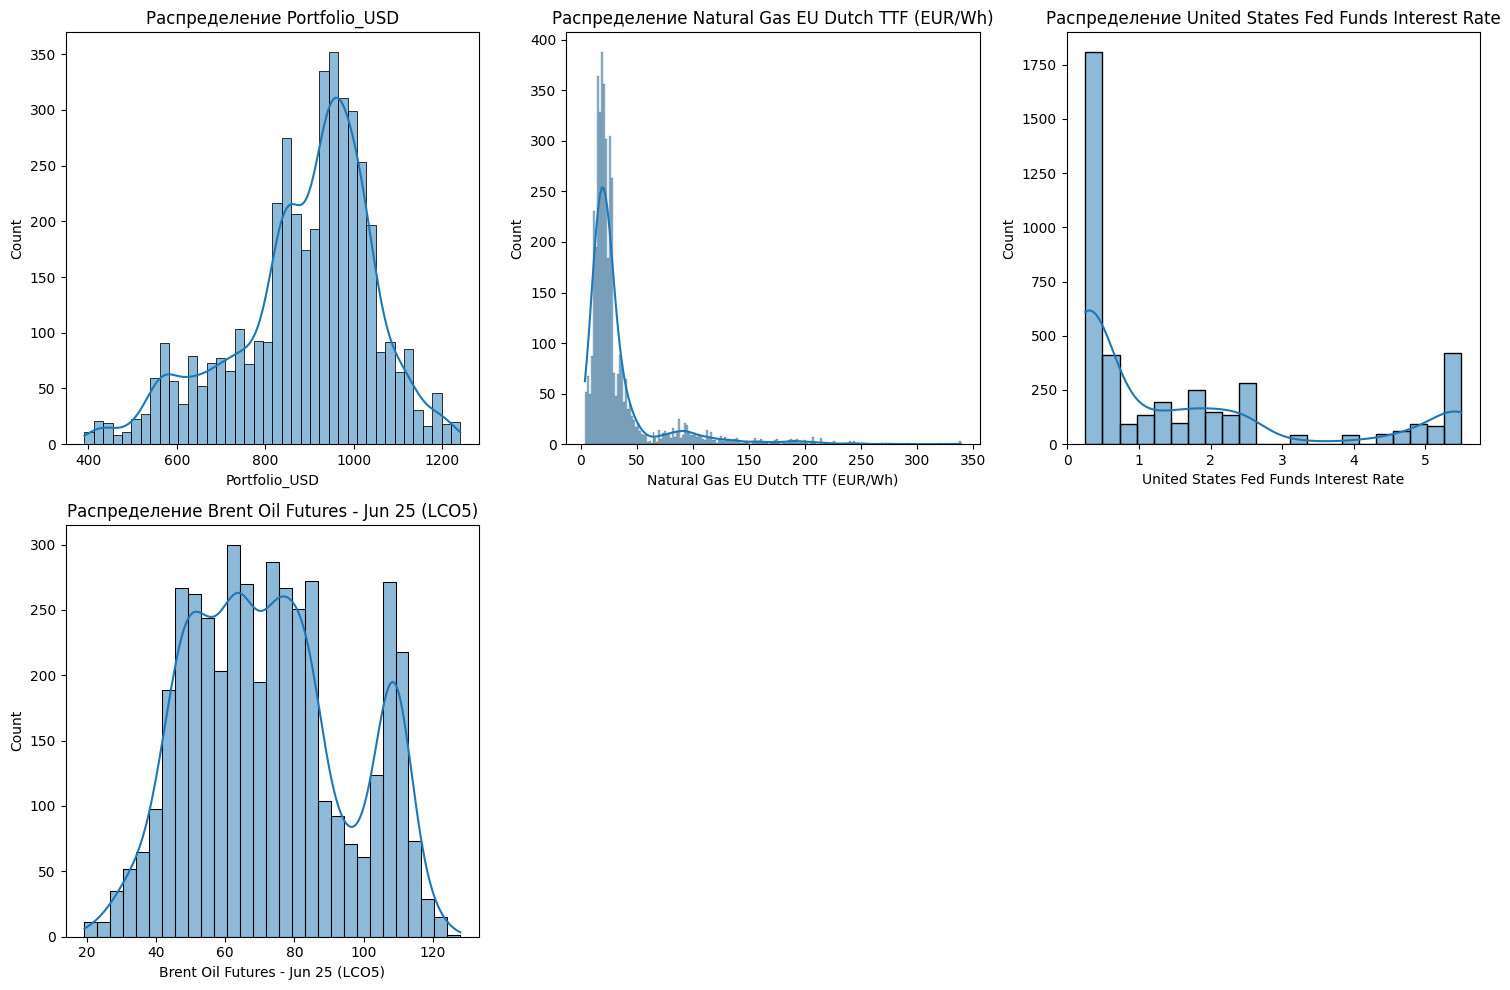

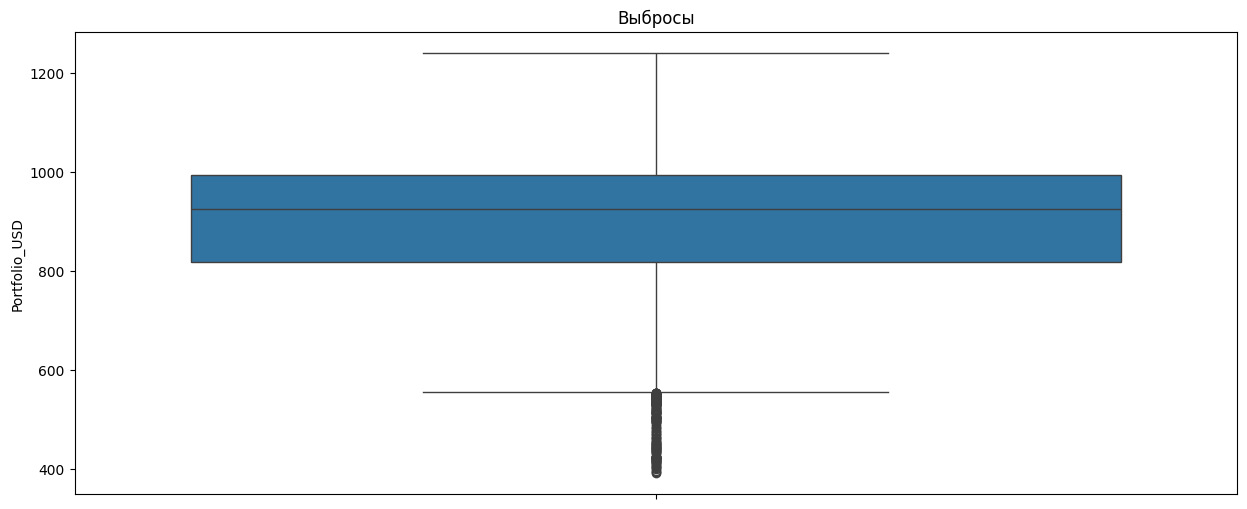

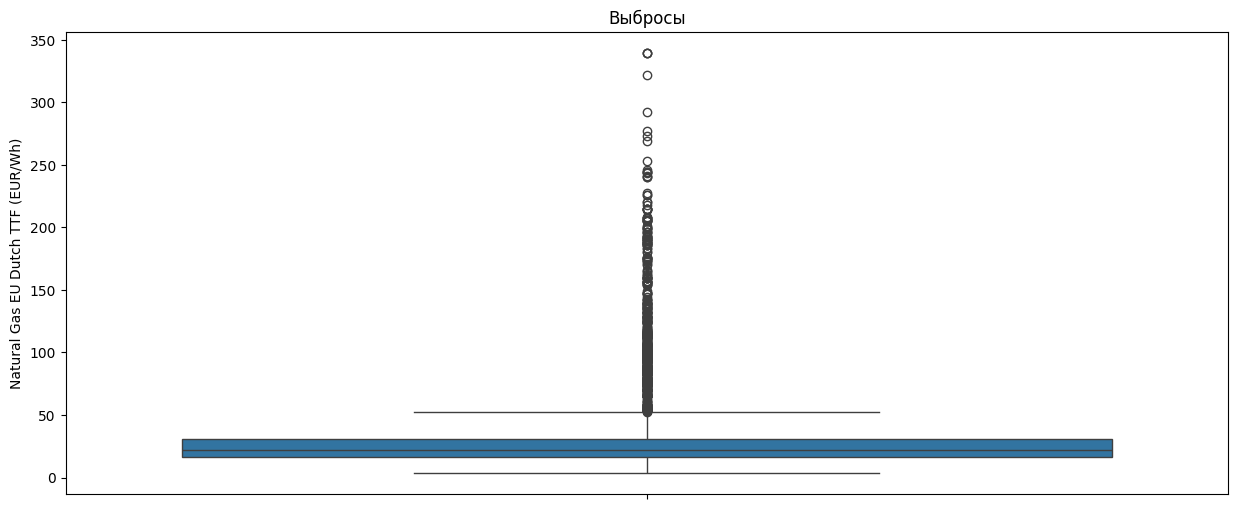

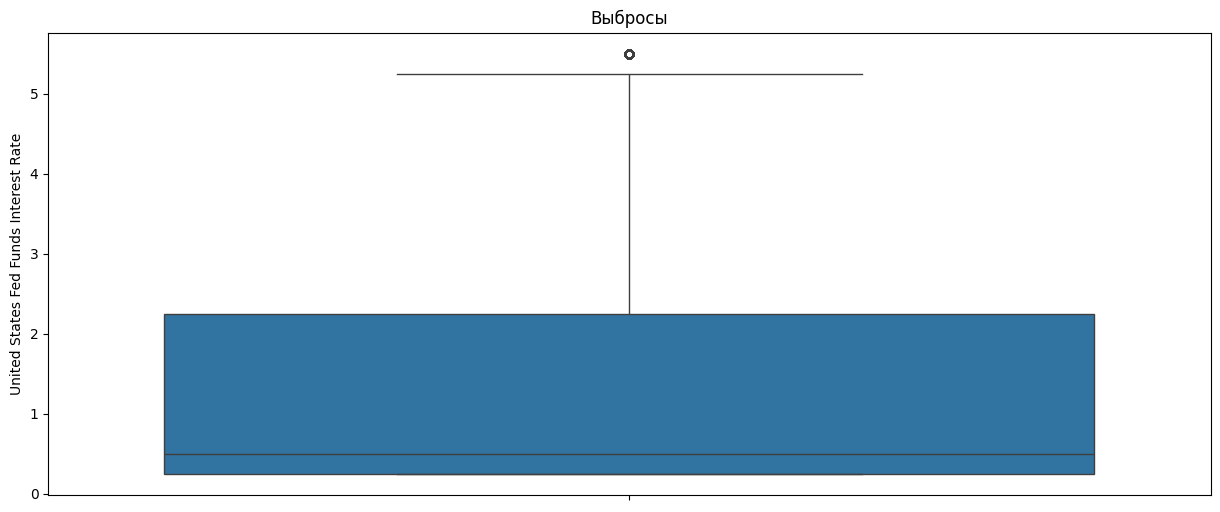

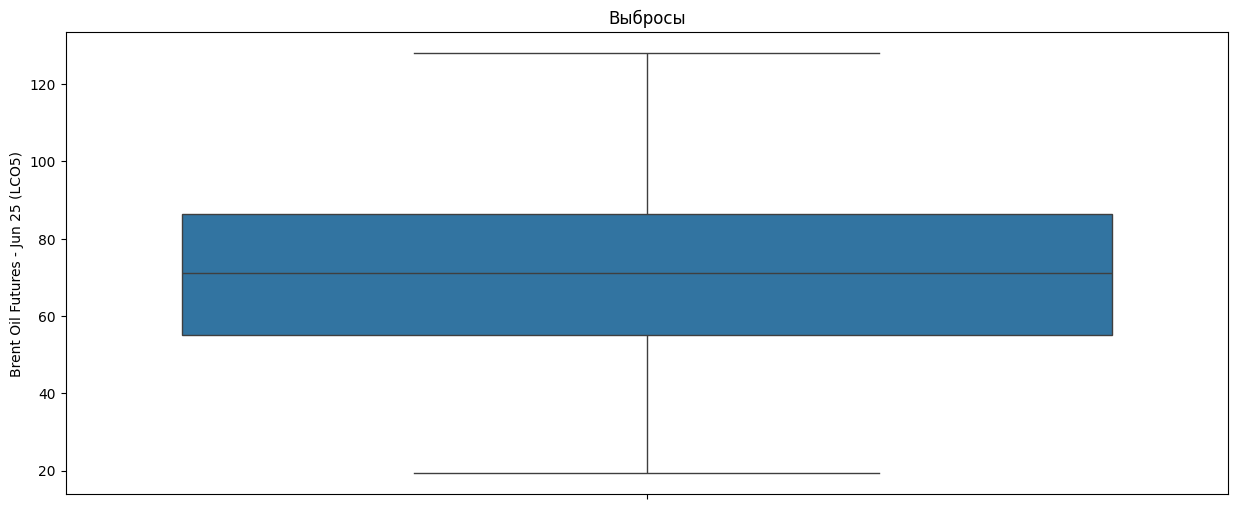

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Список признаков
features = train_imputed.columns

# Гистограммы
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(train_imputed[feature], kde=True)
    plt.title(f'Распределение {feature}')
plt.tight_layout()
plt.show()

for column_name in train_imputed.columns:
    # Ящики с усами
    plt.figure(figsize=(15, 6))
    sns.boxplot(data=train_imputed[column_name])
    plt.xticks(rotation=45)
    plt.title("Выбросы")
    plt.show()

In [12]:
import pandas as pd

# Описательные статистики
stats = train_imputed.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).transpose()
stats["IQR"] = stats["75%"] - stats["25%"]

# Считаем границы выбросов и количество
outliers_info = []
for col in train_imputed.columns:
    q1 = stats.loc[col, "25%"]
    q3 = stats.loc[col, "75%"]
    iqr = stats.loc[col, "IQR"]
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    mask_low = (train_imputed[col] < lower_bound)
    mask_high = (train_imputed[col] > upper_bound)

    outliers_info.append({
        "Признак": col,
        "Выбросы_низ": mask_low.sum(),
        "Выбросы_верх": mask_high.sum(),
        "Всего_выбросов": mask_low.sum() + mask_high.sum(),
        "LowerBound": lower_bound,
        "UpperBound": upper_bound
    })

# Создаем DataFrame с информацией о выбросах
outliers_df = pd.DataFrame(outliers_info).set_index("Признак")

# Объединяем со статистиками
stats = stats.merge(
    outliers_df[["Выбросы_низ", "Выбросы_верх", "Всего_выбросов", "LowerBound", "UpperBound"]],
    left_index=True,
    right_index=True
)

# Выводим результат
stats[["mean", "std", "min", "5%", "50%", "95%", "max", "IQR",
       "Выбросы_низ", "Выбросы_верх", "Всего_выбросов", "LowerBound", "UpperBound"]]

,mean,std,min,5%,50%,95%,max,IQR,Выбросы_низ,Выбросы_верх,Всего_выбросов,LowerBound,UpperBound
Portfolio_USD,888.514810,157.993992,391.34414,569.488224,924.738692,1113.224086,1241.052795,175.705652,159,0,159,554.325829,1257.148438
Natural Gas EU Dutch TTF (EUR/Wh),33.268799,36.737169,3.50900,9.964000,21.622500,109.800900,339.196000,14.547325,0,532,532,-5.744237,52.445062
United States Fed Funds Interest Rate,1.614338,1.808238,0.25000,0.250000,0.500000,5.500000,5.500000,2.000000,0,420,420,-2.750000,5.250000
Brent Oil Futures - Jun 25 (LCO5),72.698336,22.554171,19.33000,40.304000,71.115000,110.754667,127.980000,31.136667,0,0,0,8.405833,132.952500


In [13]:
lower_bound = 554.33
train_imputed["Portfolio_USD"] = train_imputed["Portfolio_USD"].clip(lower=lower_bound)
upper_bound = 109.8  # 95% перцентиль из таблицы выше
train_imputed["Natural Gas EU Dutch TTF (EUR/Wh)"] = train_imputed["Natural Gas EU Dutch TTF (EUR/Wh)"].clip(upper=upper_bound)
# Логарифмирование для уменьшения skewness
train_imputed["Natural Gas EU Dutch TTF (EUR/Wh)"] = np.log1p(train_imputed["Natural Gas EU Dutch TTF (EUR/Wh)"])

# train_imputed = train_imputed.drop(['U.S.Crude Oil Inventories'], axis=1, inplace=True)
# test_imputed = test_imputed.drop(['U.S.Crude Oil Inventories'], axis=1, inplace=True)

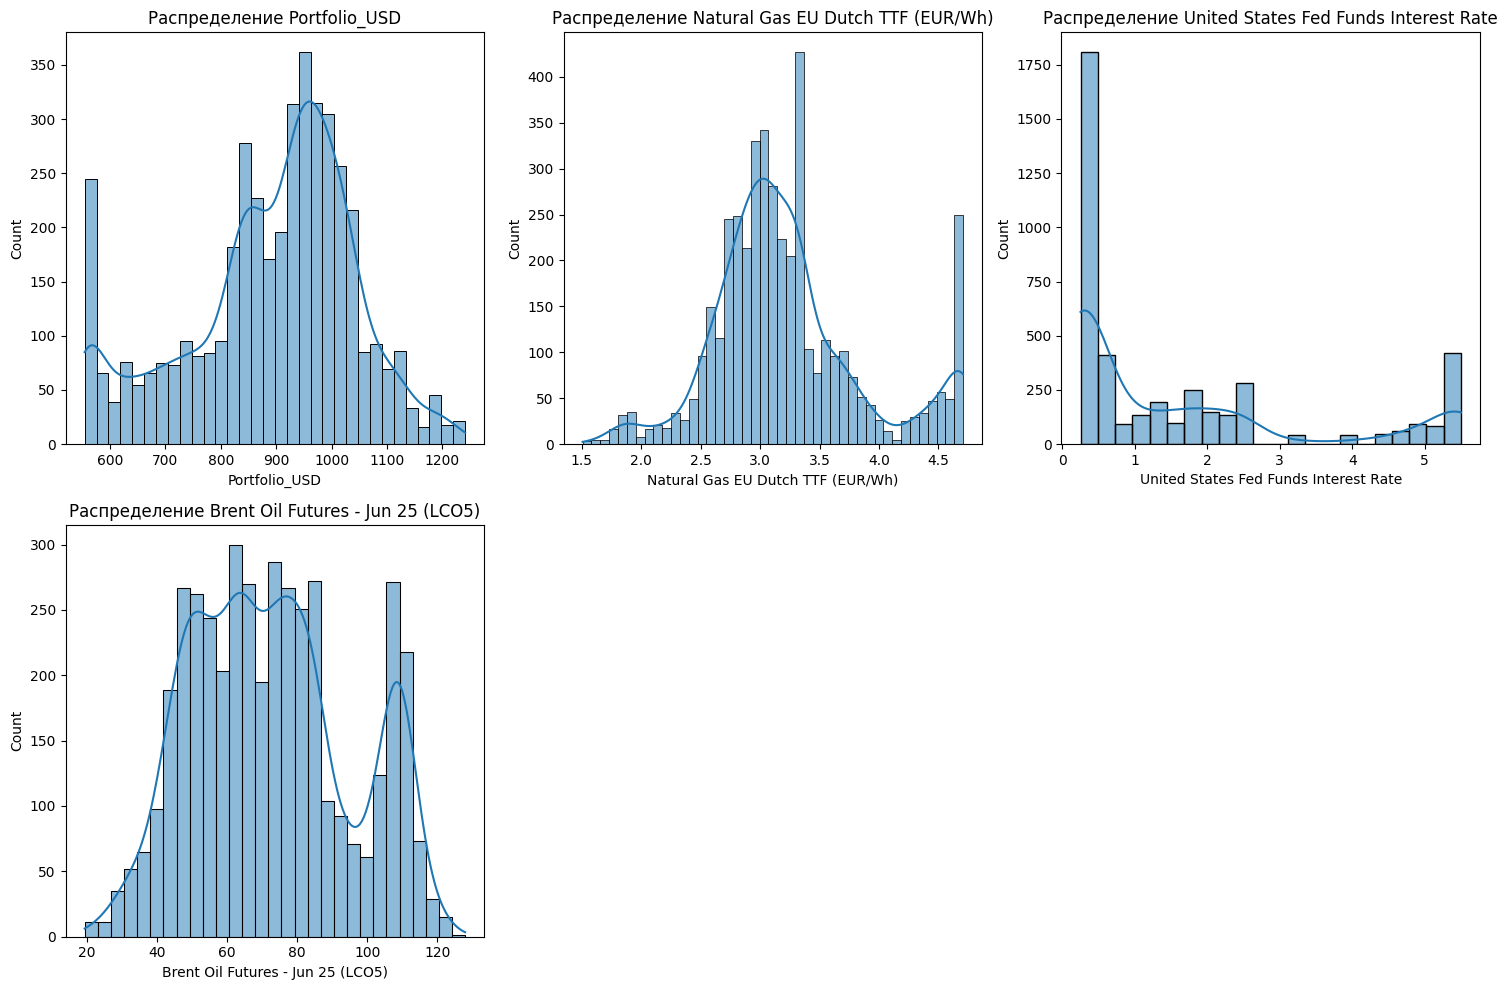

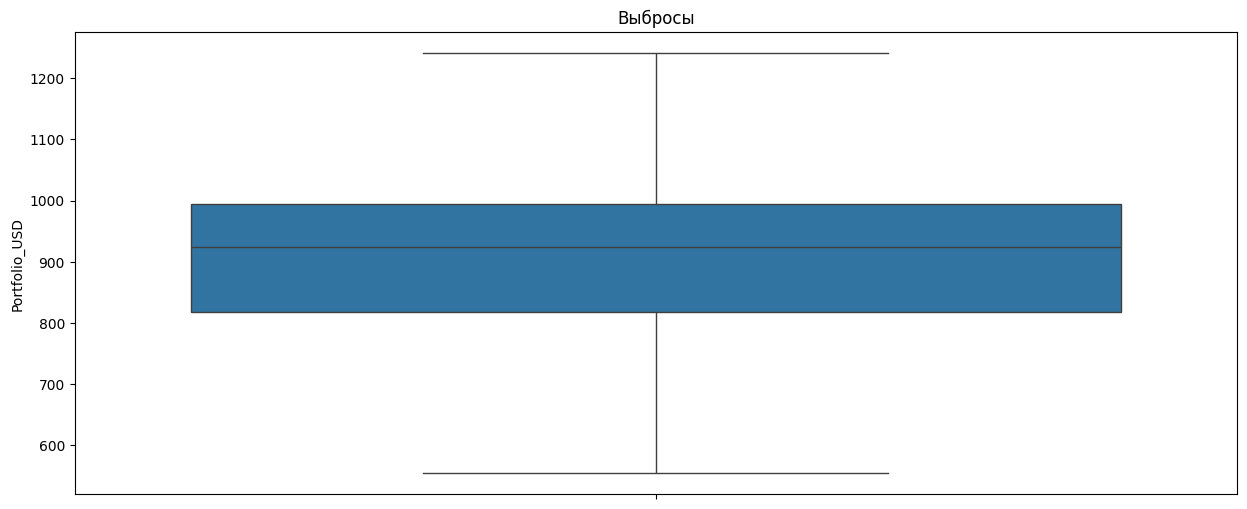

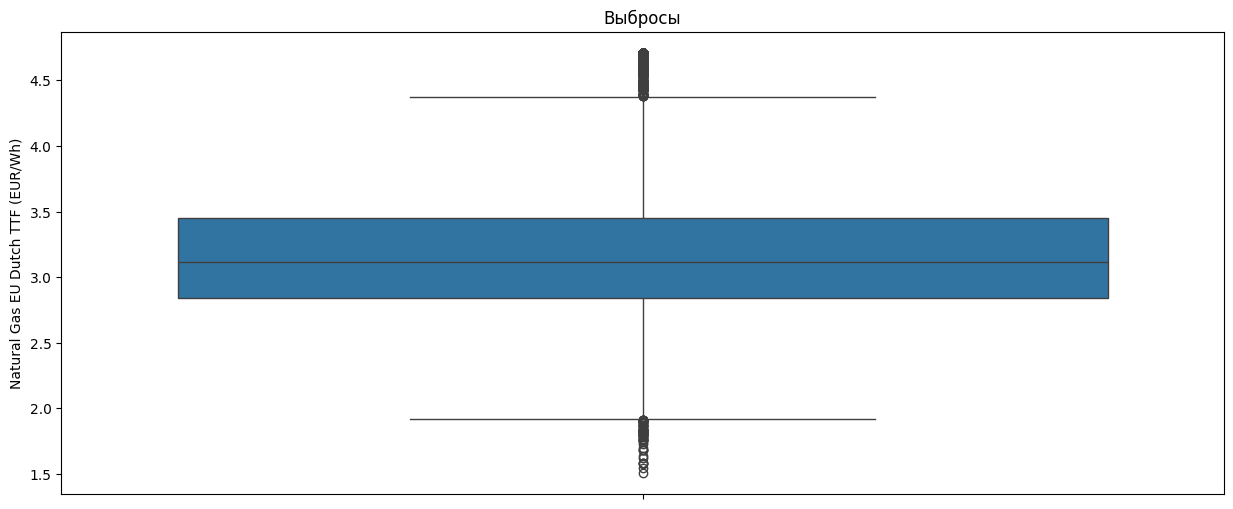

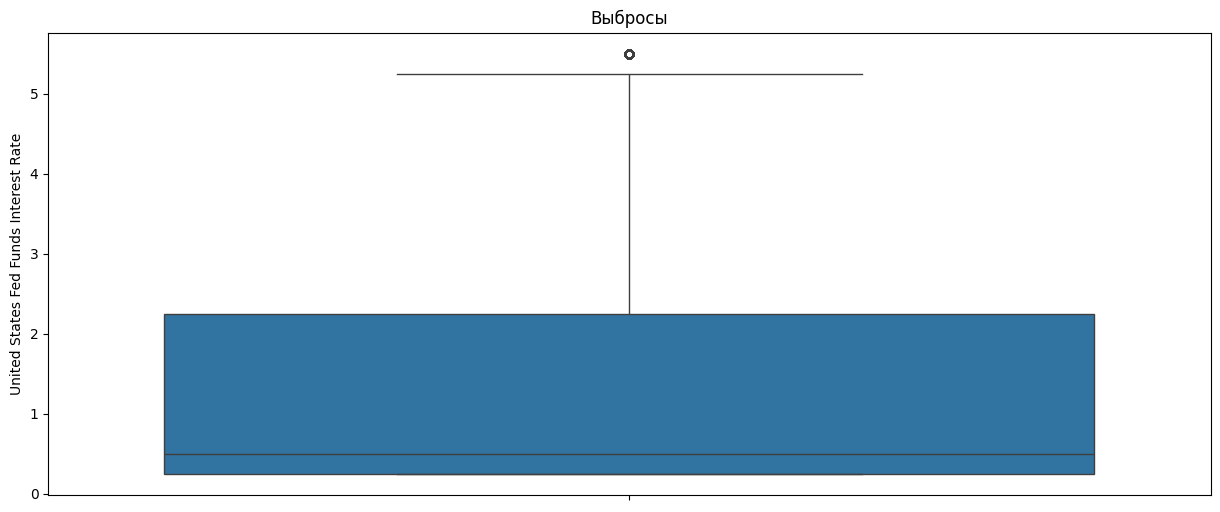

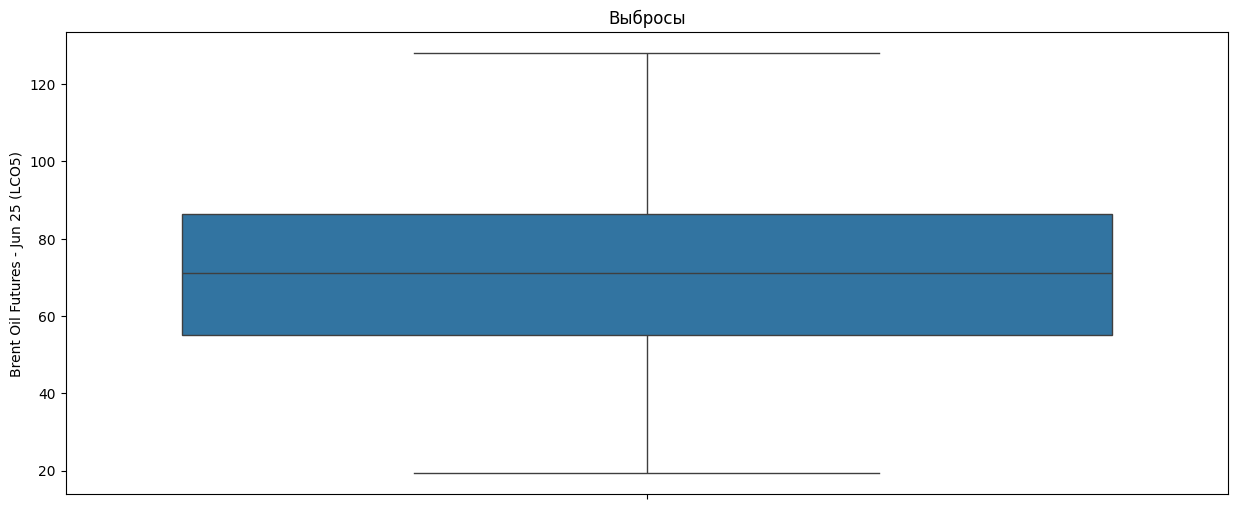

In [14]:
# Список признаков
features = train_imputed.columns

# Гистограммы
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(train_imputed[feature], kde=True)
    plt.title(f'Распределение {feature}')
plt.tight_layout()
plt.show()

for column_name in train_imputed.columns:
    # Ящики с усами
    plt.figure(figsize=(15, 6))
    sns.boxplot(data=train_imputed[column_name])
    plt.xticks(rotation=45)
    plt.title("Выбросы")
    plt.show()

In [15]:
from sklearn.preprocessing import MinMaxScaler

# Инициализация одного скейлера для всех признаков
scaler = MinMaxScaler(feature_range=(-1, 1))

# Обучение на трейне и преобразование данных
train_scaled = scaler.fit_transform(train_imputed)
test_scaled = scaler.transform(test_imputed)

In [16]:
def create_sequences(data: np.ndarray,
                     lookback: int,
                     horizon: int,
                     target_col: int = 0):
    """
    data: np.ndarray, shape (n_samples, n_features)
    lookback: int, число временных шагов во входе
    horizon: int, число временных шагов в выходе
    target_col: int, индекс столбца-цели
    """
    X, y = [], []
    for i in range(len(data) - lookback - horizon + 1):
        # окно истории
        seq_x = data[i : i + lookback, :]
        # multistep-цель
        seq_y = data[i + lookback : i + lookback + horizon, target_col]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, lookback=30, horizon=14, target_col=0)
X_test,  y_test  = create_sequences(test_scaled,  lookback=30, horizon=14, target_col=0)

In [17]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

# model = Sequential([
#     LSTM(64, input_shape=(30, 4)),
#     Dense(14)
# ])
# model.compile(optimizer='adam', loss='mse')

In [18]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(
    n_splits=5,
    max_train_size=None,  # можно ограничить размер тренировочной части
    test_size=14,         # фиксированный размер валидации
    gap=0                 # пропуск между train и test, уберегает от утечки
)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    print(f"Fold {fold+1}: Train {train_idx[0]}–{train_idx[-1]}, "
          f"Val {val_idx[0]}–{val_idx[-1]}")
    X_tr, y_tr = X_train[train_idx], y_train[train_idx]
    X_va, y_va = X_train[val_idx],   y_train[val_idx]

Fold 1: Train 0–4224, Val 4225–4238
Fold 2: Train 0–4238, Val 4239–4252
Fold 3: Train 0–4252, Val 4253–4266
Fold 4: Train 0–4266, Val 4267–4280
Fold 5: Train 0–4280, Val 4281–4294


In [19]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

val_losses = []
best_model = None
best_val_loss = float('inf')

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    # Разбиение данных
    X_tr, y_tr = X_train[train_idx], y_train[train_idx]
    X_val, y_val = X_train[val_idx],   y_train[val_idx]

    # Создание модели
    model = Sequential([
        LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.3, recurrent_dropout=0.3),
        Dense(14)
    ])
    model.compile(optimizer='adam', loss='mse')

    # Тренировка
    history = model.fit(
        X_tr, y_tr,
        epochs=20,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stop],
        verbose=1
    )


    # Валидационная ошибка
    val_loss = history.history['val_loss'][-1]
    val_losses.append(val_loss)
    print(f"Fold {fold+1} val_loss: {best_val_loss:.4f}")

    # Сохраняем лучшую модель
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

# После цикла:
print(f"\nBest val_loss: {best_val_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - loss: 0.1175 - val_loss: 0.0271
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 0.0484 - val_loss: 0.0310
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - loss: 0.0316 - val_loss: 0.0302
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - loss: 0.0257 - val_loss: 0.0274
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 0.0228 - val_loss: 0.0284
Epoch 6/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - loss: 0.0224 - val_loss: 0.0296
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
Fold 1 val_loss: 0.0296
Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - loss: 0.1162 - val_loss: 0.0142
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.0488 - val_loss: 0.0115
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.0354 - val_loss: 0.0194
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - loss: 0.0262 - val_loss: 0.0158
Epoch 5/20
13

In [20]:
mean_loss = np.mean(val_losses)
std_loss  = np.std(val_losses)
print(f"CV Mean val_loss: {mean_loss:.4f} ± {std_loss:.4f}")

CV Mean val_loss: 0.0157 ± 0.0083


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


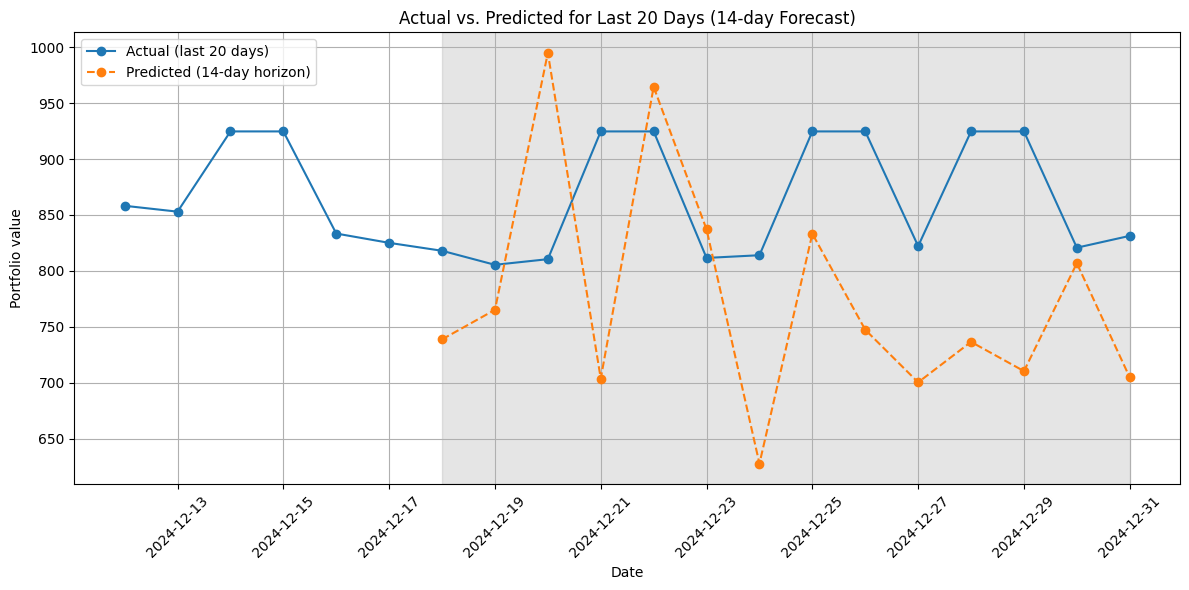

In [21]:
import matplotlib.pyplot as plt
import numpy as np

y_pred_scaled = best_model.predict(X_test)

# 1) Обратное преобразование теста
original_test = scaler.inverse_transform(test_scaled)  # (n_test_samples, n_features)

# 2) Последние 20 дат из исходного датафрейма
dates = result_df.index[-len(test_scaled):]            # индексы теста
last_20_dates = dates[-20:]                            # последние 20 дат

# 3) Прогноз последнего окна
pred_last_14_scaled = y_pred_scaled[-1]                # (14,)
zeros_after = np.zeros((14, test_scaled.shape[1] - 1)) # если целевой признак — первая колонка
to_inverse = np.hstack([pred_last_14_scaled.reshape(-1, 1), zeros_after])
y_pred_last14_real = scaler.inverse_transform(to_inverse)[:, 0]

# 4) Реальные значения за последние 20 дней
last_20_real = original_test[-20:, 0]

# 5) Построение графика
plt.figure(figsize=(12, 6))
plt.plot(last_20_dates, last_20_real, marker='o', label='Actual (last 20 days)')
plt.plot(last_20_dates[-14:], y_pred_last14_real, marker='o', linestyle='--', label='Predicted (14-day horizon)')
plt.axvspan(last_20_dates[-14], last_20_dates[-1], color='gray', alpha=0.2)

plt.xlabel('Date')
plt.ylabel('Portfolio value')
plt.title('Actual vs. Predicted for Last 20 Days (14-day Forecast)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

# Предполагается, что следующие массивы уже есть в окружении:
# actual_last_14_real  — реальные значения (shape = (14,))
# y_pred_last14_real   — прогнозы модели (shape = (14,))
# last_20_dates        — pd.DatetimeIndex длиной ≥ 14, содержащий даты для этих значений

# 1) Рассчёт метрик
actual_last_14_real = original_test[-14:, 0]

mae  = mean_absolute_error(actual_last_14_real, y_pred_last14_real)
mape = mean_absolute_percentage_error(actual_last_14_real, y_pred_last14_real)
rmse = np.sqrt(mean_squared_error(actual_last_14_real, y_pred_last14_real))
r2 = r2_score(actual_last_14_real, y_pred_last14_real)

print(f"MAE:  {mae:.4f}")
print(f"MAPE: {mape:.2%}")
print(f"RMSE: {rmse:.4f}")

# 2) Таблица сравнения факта и прогноза
df_compare = pd.DataFrame({
    "Date":      last_20_dates[-14:],
    "Actual":    actual_last_14_real,
    "Predicted": y_pred_last14_real
})

from IPython.display import display
display(df_compare)

# При необходимости вывести таблицу в стандартном виде:
# print(df_compare.to_string(index=False))

MAE:  122.2212
MAPE: 14.01%
RMSE: 141.4790


,Date,Actual,Predicted
0,2024-12-18,817.957797,738.709176
1,2024-12-19,805.393029,765.130605
2,2024-12-20,810.449585,995.003578
3,2024-12-21,924.738692,703.644810
4,2024-12-22,924.738692,964.517523
5,2024-12-23,811.563426,837.121084
6,2024-12-24,813.977743,627.544649
7,2024-12-25,924.738692,833.186283
8,2024-12-26,924.738692,747.291985
9,2024-12-27,822.136969,700.253666
